# Google Colab Setup 

Please run the code below to mount drive if you are running on colab.

Please ignore if you are running on your local machine.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# %cd /content/drive/MyDrive/MiniGPT/

# Language Modeling and Transformers

The project will consist of two broad parts. 

1. **Baseline Generative Language Model**: We will train a simple Bigram language model on the text data. We will use this model to generate a mini story. 
2. **Implementing Mini GPT**: We will implement a mini version of the GPT model layer by layer and attempt to train it on the text data. You will then load pretrained weights provided and generate a mini story. 

## Some general instructions 

1. Please keep the name of layers consistent with what is requested in the `model.py` file for each layer, this helps us test in each function independently. 
2. Please check to see if the bias is to be set to false or true for all linear layers (it is mentioned in the doc string)
3. As a general rule please read the docstring well, it contains information you will need to write the code. 
4. All configs are defined in `config.py` for the first part while you are writing the code do not change the values in the config file since we use them to test. Once you have passed all the tests please feel free to vary the parameter as you please.
5. You will need to fill in the `train.py` and run it to train the model. If you are running into memory issues please feel free to change the `batch_size` in the `config.py` file. If you are working on Colab please make sure to use the GPU runtime and feel free to copy over the training code to the notebook. 

In [3]:
# !pip install numpy torch tiktoken wandb einops # Install all required packages

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import tiktoken
import torch.nn.functional as F

In [6]:
from model import BigramLanguageModel, SingleHeadAttention, MultiHeadAttention, FeedForwardLayer, LayerNorm, TransformerLayer, MiniGPT
from config import BigramConfig, MiniGPTConfig
import tests

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
path_to_bigram_tester = "./pretrained_models/bigram_tester.pt" # Load the bigram model with name bigram_tester.pt
path_to_gpt_tester = "./pretrained_models/minigpt_tester.pt" # Load the gpt model with name minigpt_tester.pt

##  Bigram Language Model (10 points)

A bigram language model is a type of probabilistic language model that predicts a word given the previous word in the sequence. The model is trained on a text corpus and learns the probability of a word given the previous word.



### Implement the Bigram model (5 points)

Please complete the `BigramLanguageModel` class in model.py. We will model a Bigram language model using a simple MLP with one hidden layer. The model will take in the previous word index and output the logits over the vocabulary for the next word.

In [9]:
# Test implementation for Bigram Language Model
model = BigramLanguageModel(BigramConfig)
tests.check_bigram(model,path_to_bigram_tester, device)

'TEST CASE PASSED!!!'

### Training the Bigram Language Model (2.5 points)

Complete the code in `train.py` to train the Bigram language model on the text data. Please provide plots for both the training and validation in the cell below.

Some notes on the training process:

1. You should be able to train the model slowly on your local machine.
2. Training it on Colab will help with speed.
3.  <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You should see it saturate to a value close to around 5-6 but as long as you see it decreasing then saturating you should be good.
4. Please log the loss curves either on wandb, tensorboard or any other logger of your choice and please attach them below.

### Train and Valid Plots

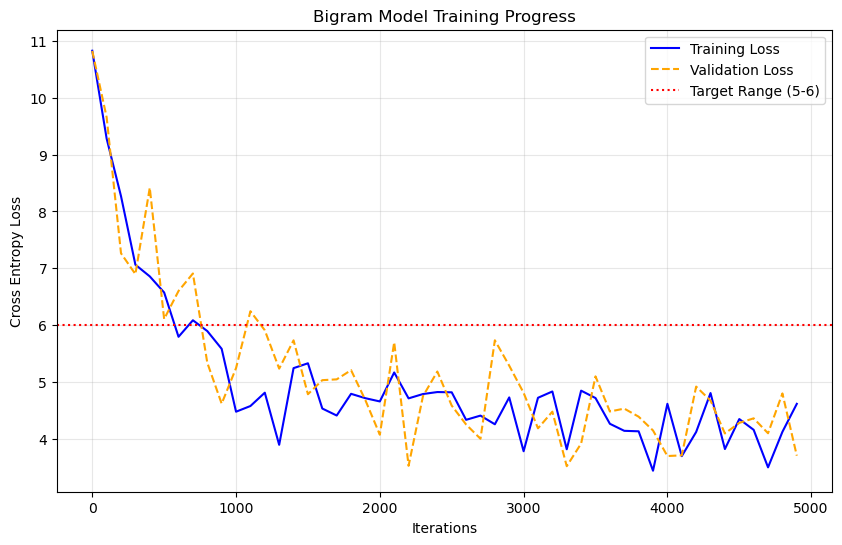

In [25]:
import matplotlib.pyplot as plt
import json

# Load the data saved by train.py
with open("loss_history.json", "r") as f:
    history = json.load(f)

plt.figure(figsize=(10, 6))
plt.plot(history["steps"], history["train"],  label='Training Loss', color='blue')
plt.plot(history["steps"], history["val"], label='Validation Loss', color='orange', linestyle='--')
plt.axhline(y=6.0, color='r', linestyle=':', label='Target Range (5-6)')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Bigram Model Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Generation (2.5 points)

Complete the code in the `generate` method of the Bigram class and generate a mini story using the trained Bigram language model. The model will take in the previous word index and output the next word index.

Start with the following seed sentence: 
    
    `"once upon a time"`
    

In [11]:
tokenizer = tiktoken.get_encoding("gpt2")

In [12]:
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, so happy and couldn't go don't come. He wanted to find a box. From that Done each other about a big and a little girl, it was kind. She GW279 subsequent teenagers universalFord given lots of fun now room to the Swim fixtures unexpected happened! It.
Lily's help her a time, "I love was help. scratchesrepe, it were scared his friend she didn'tWall back to the tornborn dad andberger allowing, they flowers around came outside the incon has a commonlyThat andTue Checking. The bird. Timmy went back on the six couldn't proponent is time, Lily wanted toMine Schiff. He could have toConf down,. He loved him little girl.
 libertarian suffer Buffyiburrelationitent distributemins Chloe swim that but gritty broccoli that he loved very happy hormonal decided to swall more eru."
"Staticvenant intimidating my merchants pastry and MarriedS Pasadenay and 57 mouse dog was time for Canceuddled TulsXM faced when he always


### Observation and Analysis

#### Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence? 

The text generated by a Bigram model is generally poor in grammar and lacking in long-term coherence. Because a Bigram model only predicts the next token based on the single preceding token, it has no "memory" of the overall sentence structure or the subject of a story.
- While it may occasionally form valid two-word pairs (e.g., "once upon"), it cannot maintain a consistent narrative or follow complex grammatical rules like subject-verb agreement over a full sentence.
- The output often appears as a "word salad" where each individual transition is statistically likely, but the collective sequence is nonsensical.

2. What are the limitations of the Bigram language model?

The primary limitation is its extremely limited context window.
- Lack of Long-Range Dependencies: Since it only looks at the immediate previous word ($n-1$), it cannot understand relationships between words that are farther apart.
- Context Blindness: It cannot maintain the "state" of a story. For example, if a story starts with "Once upon a time there was a king," a Bigram model will likely forget the "king" by the time it generates the next five words.
- Fixed Context Length: In your BigramConfig, the context_length is explicitly set to 1, which prevents the model from ever seeing more than one token at a time.

3. If the model is scaled with more parameters do you expect the bigram model to get substantially better? Why or why not?

No, scaling parameters will not make a Bigram model substantially better. * Structural Bottleneck: The limitation is architectural, not a lack of capacity. Adding more layers or neurons to the MLP (the self.linear layer) might help the model learn the statistical distribution of word pairs more accurately, but it still won't be able to "see" more than one word into the past.
- Information Deficiency: To improve coherence and grammar, a model needs a larger context_length. This is why the project moves toward Mini GPT, which uses Self-Attention to look at many previous tokens simultaneously rather than just the last one. Without increasing the context window, more parameters simply lead to a more "perfect" memory of a fundamentally limited local transition.

## Mini GPT (90 points)

We will not implement a decoder style transformer model like we discussed in lecture, which is a scaled down version of the [GPT model](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). 

All the model components follow directly from the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. The only difference is we will use prenormalization and learnt positional embeddings instead of fixed ones. But you will not need to worry about these details!

We will now implement each layer step by step checking if it is implemented correctly in the process. We will finally put together all our layers to get a fully fledged GPT model. 

<span style="color:red">Later layers might depend on previous layers so please make sure to check the previous layers before moving on to the next one.</span>

### Single Head Causal Attention (20 points)

We will first implement the single head causal attention layer. This layer is the same as the scaled dot product attention layer but with a causal mask to prevent the model from looking into the future.

Recall that Each head has a Key, Query and Value Matrix and the scaled dot product attention is calculated as : 

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

where $d_k$ is the dimension of the key matrix.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/Single_Head.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `SingleHeadAttention` class in `model.py`

In [13]:
MiniGPTConfig.num_layers = 1
MiniGPTConfig.embed_dim = 64
MiniGPTConfig.num_heads = 4
MiniGPTConfig.context_length = 10

In [14]:
model = SingleHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.embed_dim//4, MiniGPTConfig.embed_dim//4) # configs are set as such for testing do not modify

tests.check_singleheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Multi Head Attention (10 points)

Now that we have a single head working, we will now scale this across multiple heads, remember that with multihead attention we compute perform head number of parallel attention operations. We then concatenate the outputs of these parallel attention operations and project them back to the desired dimension using an output linear layer.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/MultiHead.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `MultiHeadAttention` class in `model.py` using the `SingleHeadAttention` class implemented earlier. 

In [15]:
model = MultiHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)

tests.check_multiheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Feed Forward Layer (5 points)

As discussed in lecture, the attention layer is completely linear, in order to add some non-linearity we add a feed forward layer. The feed forward layer is a simple two layer MLP with a GeLU activation in between.

Please complete the `FeedForwardLayer` class in `model.py`

In [16]:
model = FeedForwardLayer(MiniGPTConfig.embed_dim)
tests.check_feedforward(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### LayerNorm (10 points)

We will now implement the layer normalization layer. Layernorm is used across the model to normalize the activations of the previous layer. Recall that the equation for layernorm is given as:

\begin{equation}

\text{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \odot \gamma + \beta

\end{equation}

With the learnable parameters $\gamma$ and $\beta$. 

Remember that unlike batchnorm we compute statistics across the feature dimension and not the batch dimension, hence we do not need to keep track of running averages.

Please complete the `LayerNorm` class in `model.py`

In [17]:
model = LayerNorm(MiniGPTConfig.embed_dim)
tests.check_layernorm(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Transformer Layer (15 points)

We have now implemented all the components of the transformer layer. We will now put it all together to create a transformer layer. The transformer layer consists of a multi head attention layer, a feed forward layer and two layer norm layers.

Please use the following order for each component (Varies slightly from the original attention paper):
1. LayerNorm
2. MultiHeadAttention
3. LayerNorm
4. FeedForwardLayer

Remember that the transformer layer also has residual connections around each sublayer.

The below figure shows the structure of the transformer layer you are required to implement.

![prenorm_transformer](./Images/Prenorm.png)

Image Credit : [CogView](https://arxiv.org/pdf/2105.13290)

Implement the `TransformerLayer` class in `model.py`

In [18]:
model =  TransformerLayer(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_transformer(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Putting it all together : MiniGPT (15 points)

We are now ready to put all our layers together to build our own MiniGPT! 

The MiniGPT model consists of an embedding layer, a positional encoding layer and a stack of transformer layers. The output of the transformer layer is passed through a linear layer (called head) to get the final output logits. Note that in our implementation we will use [weight tying](https://arxiv.org/abs/1608.05859) between the embedding layer and the final linear layer. This allows us to save on parameters and also helps in training.

Implement the `MiniGPT` class in `model.py`

In [19]:
model = MiniGPT(MiniGPTConfig)
tests.check_miniGPT(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Attempt at training the model (5 points)

We will now attempt to train the model on the text data. We will use the same text data as before. Please scale down the model parameters in the config file to a smaller value to make training feasible. 

Use the same training script we built for the Bigram model to train the MiniGPT model. If you implemented it correctly it should work just out of the box!

**NOTE** : We will not be able to train the model to completion in this assignment. Unfortunately, without access to a relatively powerful GPU, training a large enough model to see good generation is not feasible. However, you should be able to see the loss decreasing over time. <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You do not need to run this for more than 5000 iterations or 1 hour of training.

### Train and Valid Plots

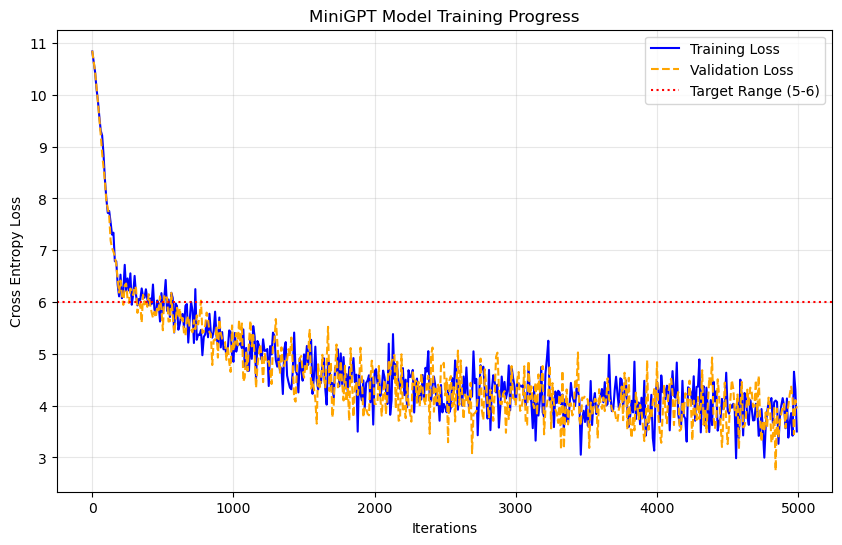

In [20]:
import matplotlib.pyplot as plt
import json

# Load the data saved by train.py
with open("loss_history.json", "r") as f:
    history = json.load(f)

plt.figure(figsize=(10, 6))
plt.plot(history["steps"], history["train"],  label='Training Loss', color='blue')
plt.plot(history["steps"], history["val"], label='Validation Loss', color='orange', linestyle='--')
plt.axhline(y=6.0, color='r', linestyle=':', label='Target Range (5-6)')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('MiniGPT Model Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Generation (5 points)


Perform generation with the model that you trained. Copy over the generation function you used for the Bigram model not the `miniGPT` class and generate a mini story using the same seed sentence. 

    `"once upon a time"`

In [21]:
tokenizer = tiktoken.get_encoding("gpt2")

In [22]:
from config import MiniGPTConfig

In [23]:
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    ))

Generating text starting with: torch.Size([4])
Once upon a time, there was a little boy named Tim. She loved to be friends to help Timmy for the water and the table. She felt sad to show him. They were small and climbed down the park and found up all played together.
One day, the small girl named Lily juice. Lily was a new house with his friends. From that day on, Timmy learned that your best friends could be mean his dad. They share his friends and again when he for her's be playing in them. Timmy says. So, the bird found a hot atheism braces people. She destroyer was sad and ate a trees. They saw a while play outside and saw its boat until it all night, Lily went to the street.
You saw the next day, green primaries told the animals that sometimes one it is an for kitchen. Timmy asked her to help his king to her home. The cat said, " bright wholly and it.otive has a big, the pear.
Suddenly,


Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence? 
Compared to the Bigram model, the text generated by the Mini GPT shows a massive improvement in local grammar and short-term coherence.

- Contextual Awareness: Because of the MultiHeadAttention mechanism, the model can "remember" words from earlier in the sentence. It can maintain subject-verb agreement and use appropriate pronouns more effectively.

- Structure: The text will look more like English and less like a "word salad." It can often form complete, grammatically plausible sentences.

- Coherence Limits: While much better than the Bigram model, the "Mini" version (especially with a small context_length like 10 or 64) will still struggle with long-term plot consistency. It might start a sentence about a "dog" and end it talking about a "cat" if the dog was mentioned too many tokens ago.

2. If the model is scaled with more parameters, do you expect the GPT model to get substantially better? Why or why not?
Yes, the GPT model will get substantially better with scaling. This is a fundamental difference between the Bigram and Transformer architectures.

- Learning Capacity: Adding more layers (num_layers) and a larger embedding dimension (embed_dim) allows the model to learn more complex relationships, such as nuances in tone, advanced vocabulary, and subtle grammatical rules.

- Context Window: Scaling the context_length (e.g., from 64 to 2048) allows the model to maintain coherence over entire paragraphs or chapters, which is how models like GPT-4 function.

- Emergent Abilities: As shown in "Scaling Laws for Neural Language Models," increasing parameters, data, and compute leads to a predictable and significant decrease in loss (perplexity). Unlike the Bigram model, which is bottlenecked by only looking at one word, the Transformer has an architecture designed to actually utilize those extra parameters to build a sophisticated world model.

### Scaling up the model (5 points)

To show that scale indeed will help the model learn we have trained a scaled up version of the model you just implemented. We will load the weights of this model and generate a mini story using the same seed sentence. Note that if you have implemented the model correctly just scaling the parameters and adding a few bells and whistles to the training script will results in a model like the one we will load now. 

In [24]:
from model import MiniGPT
from config import MiniGPTConfig

In [63]:
path_to_trained_model = "pretrained_models/best_train_loss_checkpoint.pth"

In [64]:
ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if using GPU

In [65]:
# Set the configs for scaled model 
MiniGPTConfig.context_length = 512
MiniGPTConfig.embed_dim = 256
MiniGPTConfig.num_heads = 16
MiniGPTConfig.num_layers = 8

In [66]:
# Load model from checkpoint
model = MiniGPT(MiniGPTConfig)
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [67]:
tokenizer = tiktoken.get_encoding("gpt2")

In [68]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time there was a little girl named Lola. She was three years old and loved to try new things. One day, she wanted to go for a ride in the colorful country.
So, Lola ran to the fields and started to walk down the street. As she looked around, she saw a big furry white horse! She was so excited, she couldn't wait to meet the horse.
The horse started to walk and Lola felt a tug on her leads. She was sojiang deeply, and didn't want to end up with her judging. But then the horse walked down the street, blocking her way. Lola was scared, but she knew she had to accept it. 
Finally, Lola stretched her arms and giggled that the horse was a regulators. camp was herefficiency so happy that she had accepted the rules and it made her celebrate. From then on, she started school lots more than ever before.Once upon a time, there was a baby named


## Bonus (10 points, writing)

The following are some open ended questions that you can attempt if you have time. You will get 2.5 points for each one answered correctly.

1. The model we have implemented is a decoder only model. How does the encoder part look like?
2. What are some improvements we can add to the training script to make training more efficient and faster? 
3. What are some improvements we can add to inference to improve generation?
4. What are some improvements we can make to the architecture?